In [1]:
from pydtmc import MarkovChain
import numpy as np
import itertools
from sb3_contrib import RecurrentPPO
import os
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

In [2]:
NPH = 10
mu = 250
sigma = 15
PEN = 20

In [3]:
binarylists = [["0","1"] for n in range(NPH)]
ST = []
for element in itertools.product(*binarylists):
    ST.append("".join(element))

In [4]:
def pad_sequences(sequences, maxlen, padding='post', value=0.):
    # Initialize a padded array of the correct shape with the padding value
    padded_sequences = np.full((maxlen, len(sequences[0])), value)
    
    # Determine how much padding is required
    padding_size = maxlen - len(sequences)
    
    # Apply the padding
    if padding == 'post':
        padded_sequences[:len(sequences)] = sequences  # Fill in the sequence
    elif padding == 'pre':
        padded_sequences[padding_size:] = sequences  # Fill in the sequence at the end
    
    return padded_sequences


def standardize(claims):
    """
    Normalize the claims data using standardization (z-score normalization).

    :param claims: A list of lists where each inner list represents the claims for a policyholder.
    :return: Normalized claims data.
    """
    # Flatten the list of lists to compute global mean and std
    flattened_claims = [claim for policyholder in claims for claim in policyholder]
    mean_claim = np.mean(flattened_claims)
    std_claim = np.std(flattened_claims)

    # Apply standardization
    standardized_claims = [[(claim - mean_claim) / std_claim if std_claim > 0 else 0 for claim in policyholder] 
                           for policyholder in claims]
    
    if np.isnan(standardized_claims).any():
        raise ValueError("NaN values found in standardized claims")
    return standardized_claims

In [5]:
p_00 = 0.85
p_01 = 0.15
p_10 = 0.7
p_11 = 0.3

def tp(from_state, to_state):
    # Define base probabilities
    
    # Count the number of sick individuals in the 'from' state
    n_sick = from_state.count('1')
    
    # Adjust probabilities for healthy individuals getting sick
    adjusted_p_00 = p_00 - 0.05 * n_sick
    adjusted_p_01 = p_01 + 0.05 * n_sick
    
    # Compute the transition probability as the product of individual probabilities
    prob = 1.0
    for f, t in zip(from_state, to_state):
        if f == '0' and t == '0':
            prob *= adjusted_p_00
        elif f == '0' and t == '1':
            prob *= adjusted_p_01
        elif f == '1' and t == '0':
            prob *= p_10
        elif f == '1' and t == '1':
            prob *= p_11
    
    return prob

PTM = [[] for n in range(pow(2,NPH))]

for n in range(pow(2,NPH)):
    for m in range(pow(2,NPH)):
        PTM[n].append(tp(ST[n],ST[m]))
mc = MarkovChain(PTM,ST)

In [6]:
np.random.seed(22)
scales = 100 + np.random.normal(0,20,size=NPH)
shapes = 2*np.ones(shape=(NPH,))+np.random.normal(0,0.2,size=NPH)

array([196.88849267, 138.20140339, 257.57001328, 204.75315073,
       161.26422924, 176.79508149, 254.45606152, 172.44820268,
       259.27173497, 151.11087431])

In [7]:
def claim(state, shapes, scales):
    ret = []
    for ph in range(len(state)):
        if state[ph] == "1":
            ret.append(np.random.gamma(scales[ph],shapes[ph]))
        else:
            ret.append(0)
    return ret
def simstep(shapes, scales, init, currst = ST[0]):
    x = mc.next(currst)
    init.append(claim([_ for _ in x],shapes,scales))
    return (init, x)

In [8]:
class healthysick(Env):
    def __init__(self, shapes, scales):
        self.shapes = shapes
        self.scales = scales
        self.action_space = Box(0,1,shape=(1,))
        self.T = 6
        self.observation_space = Box(0,np.inf,shape=(self.T,NPH))
        
        self.sicks = np.random.choice(ST)
        
        self.state = simstep(self.shapes,self.scales,[[0 for n in range(NPH)]],self.sicks)
        
        self.sicks = self.state[1]
        
        self.claims = [self.state[0][-1]]
        self.rave = np.array(self.claims).mean()
        self.newPP = np.array(self.claims)[-1].mean()
        self.manual_rates = np.random.normal(mu,sigma,size=self.T)
        self.timestep = 1
        self.american_preds = []
        self.american_thresh = 12000
        self.american_err = 0
        
    def set_amer_thresh(self,t):
        self.american_thresh = t
        
    def step(self,action):
        
        self.rave = np.array(self.claims).mean()
        self.state = simstep(self.shapes, self.scales, self.claims, self.sicks)
        self.claims = self.state[0]
        self.sicks = self.state[1]
        self.timestep += 1
        self.newPP = np.array(self.claims)[-1].mean()
        pred = -abs(action*self.rave + (1 - action)*self.manual_rates[self.timestep-2] - self.newPP)
        Z = np.sqrt(NPH*self.timestep / self.american_thresh)
        self.american_preds.append(Z*self.rave + (1 - Z)*self.manual_rates[self.timestep-2])
        self.american_err += abs(self.american_preds[-1] - self.newPP)
        info = {}
        done = self.timestep == self.T
        ### PERCENTAGE ERROR MAY DO BETTER
        reward = pred - (((abs(action - 1) < 0.1) or (action < 0.1)) and (self.timestep < 0.5*env.T)) * PEN
        self.unpenalized_reward = -pred
        return pad_sequences(standardize(self.claims),padding="post",maxlen=self.T), reward, done, info, info
    
    def reset(self,seed=None):
        self.timestep = 1
        self.T = 6
        self.manual_rates = np.random.normal(mu,sigma,size=self.T)
        self.state = simstep(self.shapes,self.scales,[[0 for n in range(NPH)]],self.sicks)
        self.sicks = self.state[1]
        self.claims = [self.state[0][-1]]
        self.american_preds = []
        self.american_err = 0
        return pad_sequences(standardize(self.claims),padding="post",maxlen=self.T), None

In [9]:
env = healthysick(shapes, scales)

In [10]:
model = RecurrentPPO("MlpLstmPolicy",env,verbose=1,gamma=0.95, learning_rate=0.005)
stop_callback = StopTrainingOnRewardThreshold(reward_threshold = -200, verbose=1)
eval_callback = EvalCallback(env,
                             callback_on_new_best = stop_callback,
                             eval_freq=5000,
                             best_model_save_path = "cmdqn4f.zip",
                             verbose=1)
model.learn(total_timesteps=1000000,callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -724     |
| time/              |          |
|    fps             | 136      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5           |
|    ep_rew_mean          | -695        |
| time/                   |             |
|    fps                  | 50          |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.004332696 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss   

C:\Users\acriisdu\AppData\Roaming\Python\Python310\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Stopping training because the mean reward -144.44  is above the threshold -200


In [24]:
env.set_amer_thresh(12000)
amerr = []
prederr = []
weight_choices = []
M = 1000
for m in range(M):
    lstm_states = None
    num_envs = 1
    vec_env = model.get_env()
    obs = vec_env.reset()
    W = []
    ave = []
    amerr_ = []
    rew = 0
    # Episode start signals are used to reset the lstm states
    episode_starts = np.ones((num_envs,), dtype=bool)
    for n in range(env.T):
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action[0])
        W.append(action[0][0])
        ave.append(np.array(env.claims).mean())
        rew += env.unpenalized_reward
        episode_starts = dones
        amerr_.append(env.american_err)
    if m % 100 == 0:
        print(m)
    amerr.append(max(amerr_))
    prederr.append(rew)
    weight_choices.append(W)
np.mean([1 - x/y for x, y in zip(prederr,amerr)])

0
100
200
300
400
500
600
700
800
900


0.7452836133134972

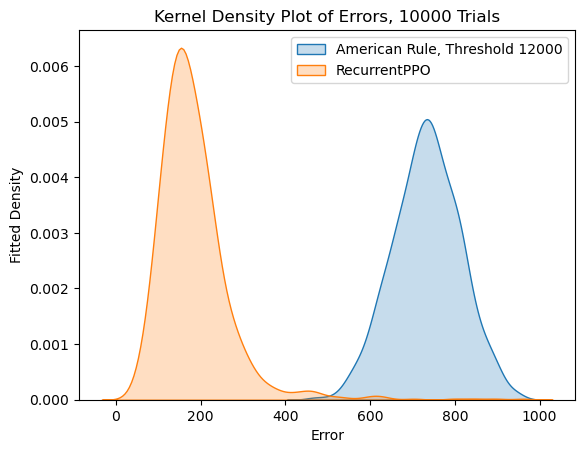

In [25]:
import seaborn as sns
sns.kdeplot(amerr,fill=True)#,bins = 50)
sns.kdeplot(prederr,fill=True)
plt.title("Kernel Density Plot of Errors, 10000 Trials")
plt.legend(["American Rule, Threshold 12000", "RecurrentPPO"])
plt.xlabel("Error")
plt.ylabel("Fitted Density")
plt.show()

In [26]:
env.set_amer_thresh(12000)
amerr = []
prederr = []
weight_choices = []
M = 10000
for m in range(M):
    lstm_states = None
    num_envs = 1
    vec_env = model.get_env()
    obs = vec_env.reset()
    W = []
    ave = []
    amerr_ = []
    rew = 0
    # Episode start signals are used to reset the lstm states
    episode_starts = np.ones((num_envs,), dtype=bool)
    for n in range(env.T):
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action[0])
        W.append(action[0][0])
        ave.append(np.array(env.claims).mean())
        rew += env.unpenalized_reward
        episode_starts = dones
        amerr_.append(env.american_err)
    if m % 1000 == 0:
        print(m)
    amerr.append(max(amerr_))
    prederr.append(rew)
    weight_choices.append(W)
np.mean([1 - x/y for x, y in zip(prederr,amerr)])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


0.7465593460478134

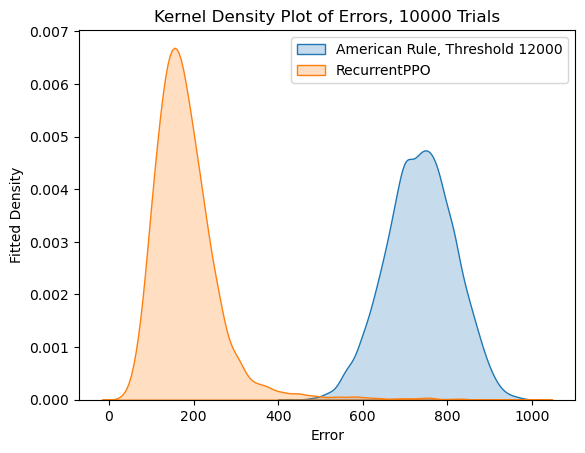

In [27]:
sns.kdeplot(amerr,fill=True)#,bins = 50)
sns.kdeplot(prederr,fill=True)
plt.title("Kernel Density Plot of Errors, 10000 Trials")
plt.legend(["American Rule, Threshold 12000", "RecurrentPPO"])
plt.xlabel("Error")
plt.ylabel("Fitted Density")
plt.show()

In [28]:
env.set_amer_thresh(4000)
amerr = []
prederr = []
weight_choices = []
M = 10000
for m in range(M):
    lstm_states = None
    num_envs = 1
    vec_env = model.get_env()
    obs = vec_env.reset()
    W = []
    ave = []
    amerr_ = []
    rew = 0
    # Episode start signals are used to reset the lstm states
    episode_starts = np.ones((num_envs,), dtype=bool)
    for n in range(env.T):
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action[0])
        W.append(action[0][0])
        ave.append(np.array(env.claims).mean())
        rew += env.unpenalized_reward
        episode_starts = dones
        amerr_.append(env.american_err)
    if m % 1000 == 0:
        print(m)
    amerr.append(max(amerr_))
    prederr.append(rew)
    weight_choices.append(W)
np.mean([1 - x/y for x, y in zip(prederr,amerr)])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


0.7364289994191241

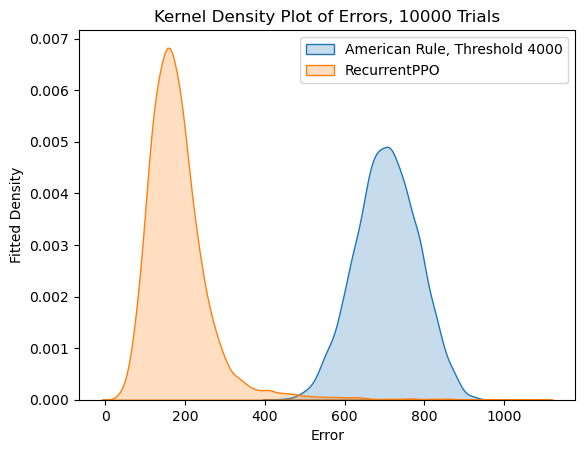

In [29]:
sns.kdeplot(amerr,fill=True)#,bins = 50)
sns.kdeplot(prederr,fill=True)
plt.title("Kernel Density Plot of Errors, 10000 Trials")
plt.legend(["American Rule, Threshold 4000", "RecurrentPPO"])
plt.xlabel("Error")
plt.ylabel("Fitted Density")
plt.show()

In [30]:
env.set_amer_thresh(20000)
amerr = []
prederr = []
weight_choices = []
M = 10000
for m in range(M):
    lstm_states = None
    num_envs = 1
    vec_env = model.get_env()
    obs = vec_env.reset()
    W = []
    ave = []
    amerr_ = []
    rew = 0
    # Episode start signals are used to reset the lstm states
    episode_starts = np.ones((num_envs,), dtype=bool)
    for n in range(env.T):
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action[0])
        W.append(action[0][0])
        ave.append(np.array(env.claims).mean())
        rew += env.unpenalized_reward
        episode_starts = dones
        amerr_.append(env.american_err)
    if m % 1000 == 0:
        print(m)
    amerr.append(max(amerr_))
    prederr.append(rew)
    weight_choices.append(W)
np.mean([1 - x/y for x, y in zip(prederr,amerr)])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


0.7510502978874609

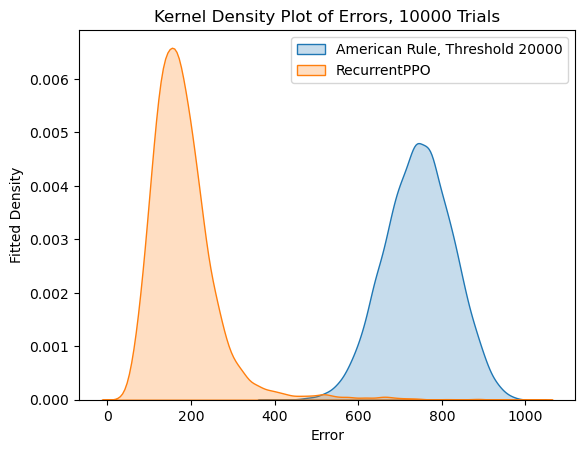

In [31]:
sns.kdeplot(amerr,fill=True)#,bins = 50)
sns.kdeplot(prederr,fill=True)
plt.title("Kernel Density Plot of Errors, 10000 Trials")
plt.legend(["American Rule, Threshold 20000", "RecurrentPPO"])
plt.xlabel("Error")
plt.ylabel("Fitted Density")
plt.show()

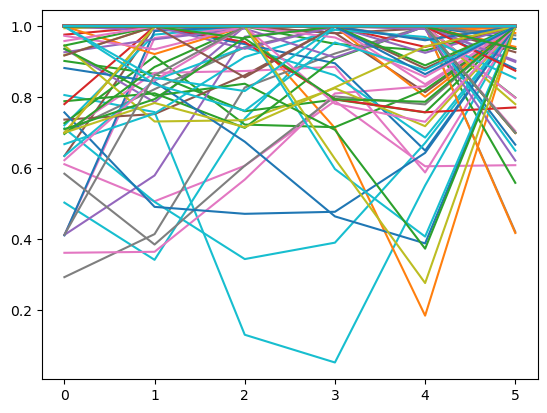

In [20]:
for x in weight_choices[:250]:
    plt.plot(x)

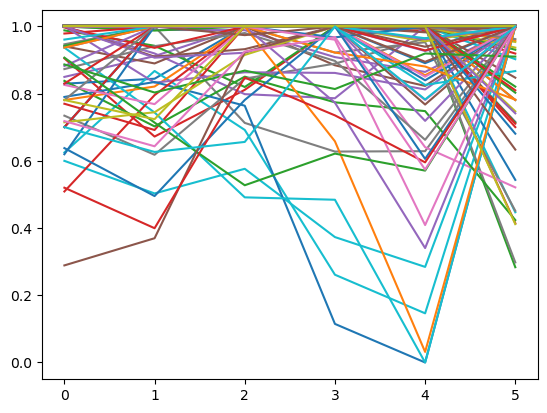

In [21]:
for x in weight_choices[250:500]:
    plt.plot(x)

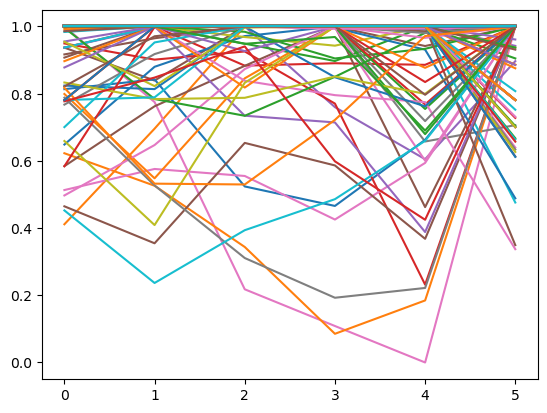

In [22]:
for x in weight_choices[500:750]:
    plt.plot(x)

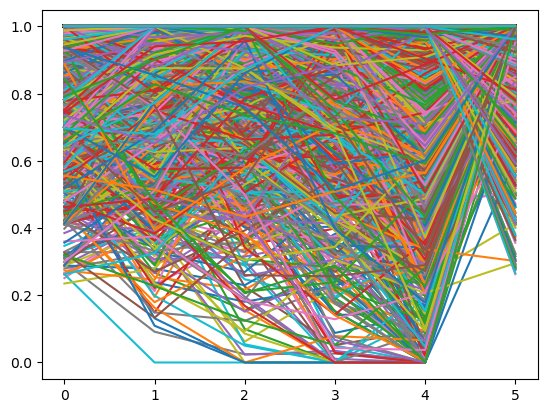

In [23]:
for x in weight_choices[750:]:
    plt.plot(x)